## Features in computer vision

Features are image locations that are "easy" to find in the future.  Indeed, one of the early feature detection techniques Lucas-Kanade, sometimes called Kanade-Lucas-Tomasi or KLT features come from a seminal paper called "Good features to track".

Edges find brightness discontinuities in an image, features find distinctive regions. There are a bunch of different feature detectors and these all have some characteristics in common: they should be quick to find, and things that are close in image-space are close in feature-space (that is, the feature representation of an object looks like the feature representation of objects that look like that object).

In [1]:
# our usual set of includes
%matplotlib inline
import cv2
import common
import video
import numpy as np
from matplotlib import pyplot as plt

input_image=cv2.imread('noidea.jpg')

## Corner detectors
If you think of edges as being lines, then corners are an obvious choice for features as they represent the intersection of two lines. One of the earlier corner detectors was introduced by Harris, and it is still a very effective corner detector that gets used quite a lot: it's reliable and it's fast. There's a tutorial explaining how Harris works on the OpenCV site : [http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html]

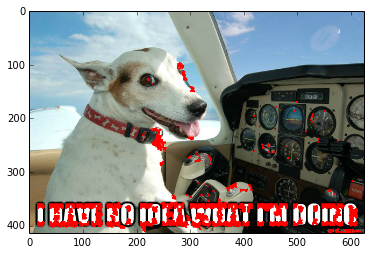

In [5]:
harris_test=input_image
#greyscale it
gray = cv2.cvtColor(harris_test,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)

# run the harris corner detector
dst = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, this is visualisation related and just makes them bigger
dst = cv2.dilate(dst,None)
#we then plot these on the input image for visualisation purposes, using bright red
harris_test[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(cv2.cvtColor(harris_test, cv2.COLOR_BGR2RGB))